<a href="https://colab.research.google.com/github/bernardo607/geocoding_project/blob/main/proyecto_geolocalizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Geolocalización de clientes**
### **Bernardo Seguí**

### El dataset original ha sido modificado levemente para resguardar los datos sensibles y se ha limitado la cantidad de registros a 1000, siendo realmente algunas decenas de miles.

### El **OBJETIVO** de este trabajo es geolocalizar direcciones y comparar los servicios de Google y Nominatim (OSM), utilizando las librerías pandas, numpy y matplotlib.

### **IMPORTANTE PARA CORRER SCRIPT:**

#### El dataset original y el archivo preprocesado de geolocalización se importan directamente del repositorio de github detallado en el código.
#### En caso de reutilizar el código con nuevos datases, deben cargarse las 'keys' personales para conectarse con las APIs de geocodificación.

### Importo librerías y cargo dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.extra.rate_limiter import RateLimiter #para agregar un delay entre solicitudes a las APIs
from geopy.geocoders import GoogleV3 #para geolocalizar con Google
from geopy.geocoders import Nominatim #para geolocalizar con OpenStreetMap
from geopy import distance #para calcular distancias versus coordenadas reales
from bokeh.plotting import figure, show, output_notebook #para graficar clientes en el mapa
from bokeh.tile_providers import CARTODBPOSITRON,get_provider,Vendors #para tener el tile del mapa
from collections import Counter #para contar palabras en direcciones fallidas
from google.colab import files #permite cargar los archivos adjuntos

In [2]:
#importo repositorio de github con dataset
!git clone -l -s https://github.com/bernardo607/geocoding_project.git geocoding_files
%cd geocoding_files
!ls

Cloning into 'geocoding_files'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 49 (delta 24), reused 29 (delta 9), pack-reused 0
Unpacking objects: 100% (49/49), done.
/content/geocoding_files
coordinates_check.csv  geocoded_Google_OSM.csv
data_raw_1000.xlsx     proyecto_geolocalizacion.ipynb


In [3]:
df=pd.read_excel("data_raw_1000.xlsx")
df.head()

,Id,IdPais,IdProvincia,IdLocalidad,IdPartido,Direccion,dwdLocalidad.Nombre,dwdPais.Nombre,dwdPartido.Nombre,dwdProvincia.Nombre
0,1467261,0,3,3154,171,RN9 209,TIO PUJIO,ARGENTINA,GENERAL SAN MARTIN,CORDOBA
1,1467263,0,3,2975,168,AV PERÓN 264,LA CALERA,ARGENTINA,COLON,CORDOBA
2,1467265,0,3,2940,167,RUTA 19 KM 33,CORDOBA,ARGENTINA,CAPITAL,CORDOBA
3,1467267,0,3,2940,167,COLECTORA SUR S/N,CORDOBA,ARGENTINA,CAPITAL,CORDOBA
4,1467271,0,3,2940,167,SUCRE Y P. ZÁRATE FERNÁNDEZ SN,CORDOBA,ARGENTINA,CAPITAL,CORDOBA


### Uppercase de nombres de columnas y renombro columnas

In [4]:
#nombres de columnas con uppercase
df.columns = df.columns.str.upper()
df.columns

Index(['ID', 'IDPAIS', 'IDPROVINCIA', 'IDLOCALIDAD', 'IDPARTIDO', 'DIRECCION',
       'DWDLOCALIDAD.NOMBRE', 'DWDPAIS.NOMBRE', 'DWDPARTIDO.NOMBRE',
       'DWDPROVINCIA.NOMBRE'],
      dtype='object')

In [5]:
#renombro algunas columnas 
df.rename(columns={'DWDLOCALIDAD.NOMBRE':'LOCALIDAD','DWDPAIS.NOMBRE':'PAIS','DWDPARTIDO.NOMBRE':'PARTIDO','DWDPROVINCIA.NOMBRE':'PROVINCIA'},inplace=True)

In [6]:
#paso a uppercase los registros en columnas relevantes que fomarán la dirección a geolocalizar
df['DIRECCION']=df['DIRECCION'].str.upper()
df['LOCALIDAD'] = df['LOCALIDAD'].str.upper()
df['PARTIDO'] = df['PARTIDO'].str.upper()
df['PROVINCIA'] = df['PROVINCIA'].str.upper()
df['PAIS'] = df['PAIS'].str.upper()

In [7]:
df.head()

,ID,IDPAIS,IDPROVINCIA,IDLOCALIDAD,IDPARTIDO,DIRECCION,LOCALIDAD,PAIS,PARTIDO,PROVINCIA
0,1467261,0,3,3154,171,RN9 209,TIO PUJIO,ARGENTINA,GENERAL SAN MARTIN,CORDOBA
1,1467263,0,3,2975,168,AV PERÓN 264,LA CALERA,ARGENTINA,COLON,CORDOBA
2,1467265,0,3,2940,167,RUTA 19 KM 33,CORDOBA,ARGENTINA,CAPITAL,CORDOBA
3,1467267,0,3,2940,167,COLECTORA SUR S/N,CORDOBA,ARGENTINA,CAPITAL,CORDOBA
4,1467271,0,3,2940,167,SUCRE Y P. ZÁRATE FERNÁNDEZ SN,CORDOBA,ARGENTINA,CAPITAL,CORDOBA


### Limpio y concateno los datos que conformarán la dirección enviada a geolocalizar

In [8]:
#Para cada columna, elimino los espacios blancos a izquierda y derecha de cada registro
df['DIRECCION'] = df['DIRECCION'].map(lambda x: x.replace(',','.').replace('S/N','SN').replace('KMS','KM').strip())
df['LOCALIDAD'] = df['LOCALIDAD'].str.strip()
df['PARTIDO'] = df['PARTIDO'].str.strip()
df['PROVINCIA'] = df['PROVINCIA'].str.strip()
df['PAIS'] = df['PAIS'].str.strip()

In [9]:
#concateno los elementos que formaran la direccion
df['DIRECCION_CONCAT'] = df['DIRECCION'].astype(str) + ',' + df['LOCALIDAD'].astype(str) + ',' + df['PARTIDO'].astype(str) + ',' +\
df['PROVINCIA'].astype(str) + ',' +df['PAIS'].astype(str)

In [10]:
#veo como queda la direccion armada
df['DIRECCION_CONCAT']

0      RN9 209,TIO PUJIO,GENERAL SAN MARTIN,CORDOBA,A...
1         AV PERÓN 264,LA CALERA,COLON,CORDOBA,ARGENTINA
2        RUTA 19 KM 33,CORDOBA,CAPITAL,CORDOBA,ARGENTINA
3      COLECTORA SUR SN,CORDOBA,CAPITAL,CORDOBA,ARGEN...
4      SUCRE Y P. ZÁRATE FERNÁNDEZ SN,CORDOBA,CAPITAL...
                             ...                        
995    ZONA RURAL MATORRALES,RIO SEGUNDO,RIO SEGUNDO,...
996    RUTA PROV 10 PARQUE INDUSTRIAL,RIO SEGUNDO,RIO...
997    CHACABUCO 87,MATORRALES,RIO SEGUNDO,CORDOBA,AR...
998    ESTANISLAO DEL CAMPO 152,RIO SEGUNDO,RIO SEGUN...
999    ZONA RURAL,MATORRALES,RIO SEGUNDO,CORDOBA,ARGE...
Name: DIRECCION_CONCAT, Length: 1000, dtype: object

### Geolocalización con Google

Este bloque conecta con la API de Google y requiere una KEY propia.
Esto fue procesado previamente, se toma el archivo geocodificado de github. Descomentar en caso de querer correr con key propia.

In [ ]:
'''
locator_google = GoogleV3(api_key='********') #completar API key de Google

geocode_google = RateLimiter(locator_google.geocode, min_delay_seconds=0.5) #delay entre paquetes para geocodificar

df['LOCATION_GOOGLE'] = df['DIRECCION_CONCAT'].apply(geocode_google, region="ar") #crea columna location

df['PUNTO_GOOGLE'] = df['LOCATION_GOOGLE'].apply(lambda loc: tuple(loc.point) if loc else None) #crea longitude, latitude y altitude de columna location

df[['LATITUDE_GOOGLE', 'LONGITUDE_GOOGLE', 'ALTITUDE_GOOGLE']] = pd.DataFrame(df['PUNTO_GOOGLE'].tolist(), index=df.index) #divide columna en latitude, longitude y altitude
'''

'\nlocator_google = GoogleV3(api_key=\'********\') #completar API key de Google\n\ngeocode_google = RateLimiter(locator_google.geocode, min_delay_seconds=0.5) #delay entre paquetes para geocodificar\n\ndf[\'LOCATION_GOOGLE\'] = df[\'DIRECCION_CONCAT\'].apply(geocode_google, region="ar") #crea columna location\n\ndf[\'PUNTO_GOOGLE\'] = df[\'LOCATION_GOOGLE\'].apply(lambda loc: tuple(loc.point) if loc else None) #crea longitude, latitude y altitude de columna location\n\ndf[[\'LATITUDE_GOOGLE\', \'LONGITUDE_GOOGLE\', \'ALTITUDE_GOOGLE\']] = pd.DataFrame(df[\'PUNTO_GOOGLE\'].tolist(), index=df.index) #divide columna en latitude, longitude y altitude\n'

In [ ]:
'''
#guarda archivo csv, puede luego ser procesado con QGIS o algún software similar
#en este caso se preprocesó y se levanta del repo de github, "geocoded_Google_OSM.csv"
df.to_csv(r"********", index = False)
'''

'\n#guarda archivo csv, puede luego ser procesado con QGIS o algún software similar\n#en este caso se preprocesó y se levanta del repo de github, "geocoded_Google_OSM.csv"\ndf.to_csv(r"********", index = False)\n'

### Geolocalización con OpenStreetMaps

Este bloque conecta con la API de OSM y requiere una KEY propia.
Esto fue procesado previamente, se toma el archivo geocodificado de github. Descomentar en caso de querer correr con key propia.

In [ ]:
'''
locator_osm = Nominatim(user_agent='********') #completar API key de OSM

geocode_osm = RateLimiter(locator_osm.geocode, min_delay_seconds=1) #delay entre paquetes para geocodificar

df['LOCATION_OSM'] = df['DIRECCION_CONCAT'].apply(locator_osm.geocode, country_codes="ar", language='es') #crea columna location

df['PUNTO_OSM'] = df['LOCATION_OSM'].apply(lambda loc: tuple(loc.point) if loc else None) #crea longitude, latitude y altitude de columna location

df[['LATITUDE_OSM', 'LONGITUDE_OSM', 'ALTITUDE_OSM']] = pd.DataFrame(df['PUNTO_OSM'].tolist(), index=df.index) #divide columna en latitude, longitude y altitude
'''


'\nlocator_osm = Nominatim(user_agent=\'********\') #completar API key de OSM\n\ngeocode_osm = RateLimiter(locator_osm.geocode, min_delay_seconds=1) #delay entre paquetes para geocodificar\n\ndf[\'LOCATION_OSM\'] = df[\'DIRECCION_CONCAT\'].apply(locator_osm.geocode, country_codes="ar", language=\'es\') #crea columna location\n\ndf[\'PUNTO_OSM\'] = df[\'LOCATION_OSM\'].apply(lambda loc: tuple(loc.point) if loc else None) #crea longitude, latitude y altitude de columna location\n\ndf[[\'LATITUDE_OSM\', \'LONGITUDE_OSM\', \'ALTITUDE_OSM\']] = pd.DataFrame(df[\'PUNTO_OSM\'].tolist(), index=df.index) #divide columna en latitude, longitude y altitude\n'

In [ ]:
'''
#guarda archivo csv, puede luego ser procesado con QGIS o algún software similar
#en este caso se preprocesó y se levanta del repo de github, "geocoded_Google_OSM.csv"
df.to_csv(r"********", index = False)
'''

'\n#guarda archivo csv, puede luego ser procesado con QGIS o algún software similar\n#en este caso se preprocesó y se levanta del repo de github, "geocoded_Google_OSM.csv"\ndf.to_csv(r"********", index = False)\n'

### Análisis de direcciones no resueltas

Leo el archivo preprocesado "geocoded_Google_OSM.csv"


In [11]:
df=pd.read_csv("geocoded_Google_OSM.csv")

In [12]:
#direcciones no resueltas Google
no_resuelto_google= pd.isna(df['PUNTO_GOOGLE']).sum()
nro_direcciones= len(df.index)
print(f'Google API: {no_resuelto_google} direcciones no resueltas sobre un total de {nro_direcciones}')
#direcciones no resueltas OSM
no_resuelto_osm= pd.isna(df['PUNTO_OSM']).sum()
nro_direcciones= len(df.index)
print(f'OpenStreetMaps: {no_resuelto_osm} direcciones no resueltas sobre un total de {nro_direcciones}')

Google API: 6 direcciones no resueltas sobre un total de 1000
OpenStreetMaps: 538 direcciones no resueltas sobre un total de 1000


#### Casos no resueltos con Google

Tomo las direcciones no resueltas y analizo las palabras más comunes para identificar patrones.

In [13]:
df_googlefail=df[df['PUNTO_GOOGLE'].isna()]
df_googlefail['DIRECCION']

402                         EEUU 5011
419     CAMINO A MONTE CRISTO KM. 4.5
459             BV LOS ALEMANES 4769
468      RUTA PROVINCIAL N94 KM 60.5
587       CAMINO A CAPILLA DE DOLORES
692    MAES. VIDAL 1702 ESQ ALB WILLI
Name: DIRECCION, dtype: object

In [14]:
results_google = Counter()
df_googlefail['DIRECCION'].str.split().apply(results_google.update)

for key, value in results_google.most_common():
    print(f'Frecuencia: {value}, Palabra: {key} ')

Frecuencia: 2, Palabra: CAMINO 
Frecuencia: 2, Palabra: A 
Frecuencia: 1, Palabra: EEUU 
Frecuencia: 1, Palabra: 5011 
Frecuencia: 1, Palabra: MONTE 
Frecuencia: 1, Palabra: CRISTO 
Frecuencia: 1, Palabra: KM. 
Frecuencia: 1, Palabra: 4.5 
Frecuencia: 1, Palabra: BV 
Frecuencia: 1, Palabra: LOS 
Frecuencia: 1, Palabra: ALEMANES 
Frecuencia: 1, Palabra: 4769 
Frecuencia: 1, Palabra: RUTA 
Frecuencia: 1, Palabra: PROVINCIAL 
Frecuencia: 1, Palabra: N94 
Frecuencia: 1, Palabra: KM 
Frecuencia: 1, Palabra: 60.5 
Frecuencia: 1, Palabra: CAPILLA 
Frecuencia: 1, Palabra: DE 
Frecuencia: 1, Palabra: DOLORES 
Frecuencia: 1, Palabra: MAES. 
Frecuencia: 1, Palabra: VIDAL 
Frecuencia: 1, Palabra: 1702 
Frecuencia: 1, Palabra: ESQ 
Frecuencia: 1, Palabra: ALB 
Frecuencia: 1, Palabra: WILLI 


Usando Google se ven sólo 6 casos no resueltos con lo cual es difícil encontrar patrones.

#### Casos no resueltos con OSM

Tomo las direcciones no resueltas y analizo las palabras más comunes para identificar patrones.

In [15]:
df_osmfail=df[df['PUNTO_OSM'].isna()]

results_osm = Counter()
df_osmfail['DIRECCION'].str.split().apply(results_osm.update)

for key, value in results_osm.most_common():
    print(f'Frecuencia: {value}, Palabra: {key} ')

Frecuencia: 63, Palabra: RUTA 
Frecuencia: 60, Palabra: DE 
Frecuencia: 43, Palabra: KM 
Frecuencia: 43, Palabra: - 
Frecuencia: 39, Palabra: AV 
Frecuencia: 29, Palabra: SAN 
Frecuencia: 27, Palabra: Y 
Frecuencia: 23, Palabra: 9 
Frecuencia: 21, Palabra: AV. 
Frecuencia: 19, Palabra: LOS 
Frecuencia: 19, Palabra: BV 
Frecuencia: 19, Palabra: ESTACION 
Frecuencia: 18, Palabra: SN 
Frecuencia: 16, Palabra: LA 
Frecuencia: 15, Palabra: CALLE 
Frecuencia: 14, Palabra: JUAN 
Frecuencia: 13, Palabra: MARTIN 
Frecuencia: 12, Palabra: ESQ. 
Frecuencia: 11, Palabra: ESQ 
Frecuencia: 11, Palabra: VELEZ 
Frecuencia: 9, Palabra: 25 
Frecuencia: 9, Palabra: V 
Frecuencia: 9, Palabra: MAYO 
Frecuencia: 9, Palabra: A 
Frecuencia: 9, Palabra: GOMEZ 
Frecuencia: 8, Palabra: ALBERDI 
Frecuencia: 8, Palabra: VDR 
Frecuencia: 8, Palabra: SARFIELD 
Frecuencia: 8, Palabra: BELGRANO 
Frecuencia: 8, Palabra: SARMIENTO 
Frecuencia: 8, Palabra: VENADO 
Frecuencia: 7, Palabra: SUR 
Frecuencia: 7, Palabra: PARQ

Usando OSM se ven 538 casos no resueltos.
Podemos notar que las palabras "RUTA", "KM", "-", "ESQ", "SN", entre otras, presentan dificultad para OSM dada su alta frecuencia de aparición. Esto parece indicar que las direcciones problemáticas son aquellas sobre las rutas, en esquinas o sin número.
Otras palabras como "AV", "DE", "SAN", "CALLE" son realmente stopwords.



### Mapa de clientes

#### Geolocalizados con Google

In [16]:
#conversion de latitud y longitud a mercator
k = 6378137
df['LONGITUDE_GOOGLE_MERCATOR']= df['LONGITUDE_GOOGLE'] * (k * np.pi/180.0)
df['LATITUDE__GOOGLE_MERCATOR'] = np.log(np.tan((90 + df['LATITUDE_GOOGLE']) * np.pi/360.0)) * k

In [17]:
output_notebook()
tile_provider = get_provider(Vendors.CARTODBPOSITRON)

#ejes
p = figure(x_axis_type="mercator", y_axis_type="mercator")

#fondo de mapa
p.add_tile(tile_provider)

#puntos en el mapa
p.circle(y = df['LATITUDE__GOOGLE_MERCATOR'],
         x = df['LONGITUDE_GOOGLE_MERCATOR'],
         fill_color='orange',fill_alpha=.5)

#detalles del titulo
p.title.text = "Clientes geolocalizados con Google"
p.title.text_color = "Orange"
p.title.text_font_size = "25px"

show(p)

#### Geolocalizados con OpenStreetMap

In [18]:
#conversion de latitud y longitud a mercator
k = 6378137
df['LONGITUDE_OSM_MERCATOR']= df['LONGITUDE_OSM'] * (k * np.pi/180.0)
df['LATITUDE__OSM_MERCATOR'] = np.log(np.tan((90 + df['LATITUDE_OSM']) * np.pi/360.0)) * k

In [19]:
output_notebook()
tile_provider = get_provider(Vendors.CARTODBPOSITRON)

#ejes
p = figure(x_axis_type="mercator", y_axis_type="mercator")

#fondo de mapa
p.add_tile(tile_provider)

#puntos en el mapa
p.circle(y = df['LATITUDE__OSM_MERCATOR'],
         x = df['LONGITUDE_OSM_MERCATOR'],
         fill_color='orange',fill_alpha=.5)

#detalles del titulo
p.title.text = "Clientes geolocalizados con OpenStreetMap"
p.title.text_color = "Orange"
p.title.text_font_size = "25px"

show(p)

##Análisis de distancia entre geocodificación y coordenadas reales en 20 puntos

In [20]:
#Se levanta el dataset con 20 coordenadas reales encontradas manualmente
df_check = pd.read_csv('coordinates_check.csv')
df_check.head(20)

,DIRECCION,LOCALIDAD,PARTIDO,PROVINCIA,PAIS,DIRECCION_CONCAT,PUNTO_GOOGLE,PUNTO_OSM,PUNTO_CHECK
0,AV. SAN MARTIN 1146,COLONIA CAROYA,COLON,CORDOBA,ARGENTINA,"AV. SAN MARTIN 1146,COLONIA CAROYA,COLON,CORDO...","-30.9996138, -64.0872934","-30.999547297959182, -64.08724358163265","-30.99980215278911, -64.08704230949608"
1,LEANDRO N. ALEM 513,OLIVA,TERCERO ARRIBA,CORDOBA,ARGENTINA,"LEANDRO N. ALEM 513,OLIVA,TERCERO ARRIBA,CORDO...","-32.0456486, -63.5665892","-32.0522301, -63.5615422","-32.045570474828665, -63.56643139880634"
2,BUENOS AIRES 446,ALTO ALEGRE,UNION,CORDOBA,ARGENTINA,"BUENOS AIRES 446,ALTO ALEGRE,UNION,CORDOBA,ARG...","-32.3456168, -62.88453699999999","-32.3456409, -62.8846617","-32.34547076339722, -62.88375712355238"
3,ITALIA 458,DEAN FUNES,ISCHILIN,CORDOBA,ARGENTINA,"ITALIA 458,DEAN FUNES,ISCHILIN,CORDOBA,ARGENTINA","-30.4282382, -64.3510048","-30.4263969, -64.3524202","-30.428419865099205, -64.35093482508893"
4,SAN MARTÍN Y FERRARI,WHEELWRIGHT,GENERAL LOPEZ,SANTA FE,ARGENTINA,"SAN MARTÍN Y FERRARI,WHEELWRIGHT,GENERAL LOPEZ...","-33.7931899, -61.2124969","-33.7925095, -61.2135192","-33.79313421432668, -61.212772607938966"
5,SANTA FE 1515 - FIRMAT,FIRMAT,GENERAL LOPEZ,SANTA FE,ARGENTINA,"SANTA FE 1515 - FIRMAT,FIRMAT,GENERAL LOPEZ,SA...","-33.458464, -61.48883","-33.458422614285716, -61.49050261428572","-33.458529733350865, -61.49042847241272"
6,HIPÓLITO YRIGOYEN 963,LAGUNA LARGA,RIO SEGUNDO,CORDOBA,ARGENTINA,"HIPÓLITO YRIGOYEN 963,LAGUNA LARGA,RIO SEGUNDO...","-31.7802849, -63.7987302","-31.7779141, -63.8009315","-31.780917281825026, -63.797816184414025"
7,CHILE 390 - SAN EDUARDO,SAN EDUARDO,GENERAL LOPEZ,SANTA FE,ARGENTINA,"CHILE 390 - SAN EDUARDO,SAN EDUARDO,GENERAL LO...","-33.8722717, -62.094869","-33.8715789, -62.0955037","-33.87214824036286, -62.09487409290343"
8,FELIX FRIAS 1490,CORDOBA,CAPITAL,CORDOBA,ARGENTINA,"FELIX FRIAS 1490,CORDOBA,CAPITAL,CORDOBA,ARGEN...","-31.401342, -64.1744111","-31.401345757142856, -64.17437879795918","-31.401300238233926, -64.17437229250959"
9,FELIX PAZ 908,CORDOBA,CAPITAL,CORDOBA,ARGENTINA,"FELIX PAZ 908,CORDOBA,CAPITAL,CORDOBA,ARGENTINA","-31.4157589, -64.231867","-31.41589227755102, -64.23186364693878","-31.415770000962247, -64.23189437674048"


In [21]:
#Google: diferencias en metros versus dirección real
list_google = []
for i in range(20):
  loc_a = df_check.iloc[i]['PUNTO_GOOGLE']
  loc_b = df_check.iloc[i]['PUNTO_CHECK']
  list_google.append(round(distance.distance(loc_a, loc_b).m))
print(f'El error promedio de Google en estos 20 casos es de {round(sum(list_google) / float(len(list_google)))} metros')

El error promedio de Google en estos 20 casos es de 36 metros


In [22]:
#OSM: diferencias en metros versus dirección real
list_osm = []
for i in range(20):
  loc_a = df_check.iloc[i]['PUNTO_OSM']
  loc_b = df_check.iloc[i]['PUNTO_CHECK']
  list_osm.append(round(distance.distance(loc_a, loc_b).m))
print(f'El error promedio de Google en estos 20 casos es de {round(sum(list_osm) / float(len(list_osm)))} metros')

El error promedio de Google en estos 20 casos es de 913 metros


In [34]:
#diferencias en metros versus dirección real ordenadas por mayor distancia
df_differences = pd.DataFrame(list(zip(list_osm, list_google)), columns =['OSM','Google'])
df_differences['DIRECCION_CONCAT'] = df_check['DIRECCION_CONCAT']
df_differences.sort_values(by=['OSM'], ascending=False).head(20)

,OSM,Google,DIRECCION_CONCAT
14,6557,3,"REMEDIO DE ESCALADA 660,RIO CEBALLOS,COLON,COR..."
12,4477,4,"PUEYRREDON 1722,CORDOBA,CAPITAL,CORDOBA,ARGENTINA"
15,3020,55,"AV. VALPARAISO 4995,CORDOBA,CAPITAL,CORDOBA,AR..."
19,1401,79,"AV. A. Y E. DICKINSON 761,LAS ROSAS,BELGRANO,S..."
1,871,17,"LEANDRO N. ALEM 513,OLIVA,TERCERO ARRIBA,CORDO..."
6,445,111,"HIPÓLITO YRIGOYEN 963,LAGUNA LARGA,RIO SEGUNDO..."
13,393,67,"PEDRO J. FRIAS 760,JESUS MARIA,COLON,CORDOBA,A..."
17,384,4,"ESPINOSA NEGRETE 313,CORDOBA,CAPITAL,CORDOBA,A..."
3,266,21,"ITALIA 458,DEAN FUNES,ISCHILIN,CORDOBA,ARGENTINA"
4,98,26,"SAN MARTÍN Y FERRARI,WHEELWRIGHT,GENERAL LOPEZ..."


Text(0.5, 1.0, 'Distancia versus punto real')

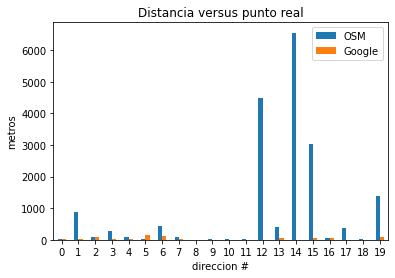

In [31]:
#gráfico de barras de los errores
bar = df_differences.plot.bar(rot=0)
bar.set_ylabel('metros')
bar.set_xlabel('direccion #')
bar.set_title('Distancia versus punto real')

##Conclusiones

*   El servicio de Google resuelve casi la totalidad de las direcciones, mientras que OpenStreetMap falla en más de la mitad.
*   De las direcciones no resueltas, especialmente en OSM, se pueden identificar palabras que complican la geolocalización, tales como: RUTA, KM, ESQ, SN.
*   De las 20 direcciones chequeadas manualmente, Google tiene menor error que OSM en 18 casos. Además el error promedio de Google en estos 20 casos es de 36 metros mientras que el de OSM es de 913 metros.
*   Ya sea con Google o con OSM, siempre que sea posible es recomendable hacer un chequeo manual de las direcciones geolocalizadas.





